In [1]:
%pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [20]:
def create_oracle(num_qubits, secret_index):
    """Create an oracle that marks the secret index state"""
    oracle = QuantumCircuit(num_qubits)
    
    # Convert secret_index to binary string
    target_state = format(secret_index, f'0{num_qubits}b')
    
    # Apply X gates where target state has 0s
    for qubit, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(qubit)
    
    # Apply multi-controlled Z gate using CZ decomposition
    oracle.h(num_qubits-1)
    oracle.mcx(control_qubits=list(range(num_qubits-1)), 
              target_qubit=num_qubits-1)
    oracle.h(num_qubits-1)
    
    # Uncompute X gates
    for qubit, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(qubit)
            
    return oracle

In [21]:
def create_diffuser(num_qubits):
    """Create the Grover diffuser"""
    qc = QuantumCircuit(num_qubits)
    
    # Apply H gates to all qubits
    qc.h(range(num_qubits))
    # Apply X gates to all qubits
    qc.x(range(num_qubits))
    
    # Apply multi-controlled Z gate
    qc.h(num_qubits-1)
    qc.mcx(control_qubits=list(range(num_qubits-1)), 
           target_qubit=num_qubits-1)
    qc.h(num_qubits-1)
    
    # Undo X gates
    qc.x(range(num_qubits))
    # Undo H gates
    qc.h(range(num_qubits))
    
    return qc

In [22]:
def grover_algorithm(secret_index, num_qubits, shots=1000):
    """Implement Grover's Algorithm to find the secret password index"""
    
    # Create quantum circuit
    qc = QuantumCircuit(num_qubits, num_qubits)
    
    # Initialize superposition
    qc.h(range(num_qubits))
    
    # Optimal number of iterations (pi/4 * sqrt(N))
    iterations = int(np.pi/4 * np.sqrt(2**num_qubits))
    
    # Apply Grover iterations
    oracle = create_oracle(num_qubits, secret_index)
    diffuser = create_diffuser(num_qubits)
    
    for _ in range(iterations):
        qc = qc.compose(oracle)
        qc = qc.compose(diffuser)
    
    # Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    
    # Run the circuit
    simulator = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts()
    
    return counts

In [23]:
import numpy as np

In [24]:
# Set parameters
num_qubits = 4
secret_index = 5  # Binary: 0101
shots = 1000

# Run algorithm
counts = grover_algorithm(secret_index, num_qubits, shots)

In [25]:
# Print results
print(f"Secret index (binary): {format(secret_index, f'0{num_qubits}b')}")
print(f"Quantum Search Result: {counts}")

Secret index (binary): 0101
Quantum Search Result: {'1001': 2, '1010': 968, '0010': 2, '1011': 1, '0101': 3, '1111': 4, '0110': 6, '0111': 4, '1101': 2, '1000': 2, '1110': 2, '0100': 3, '1100': 1}


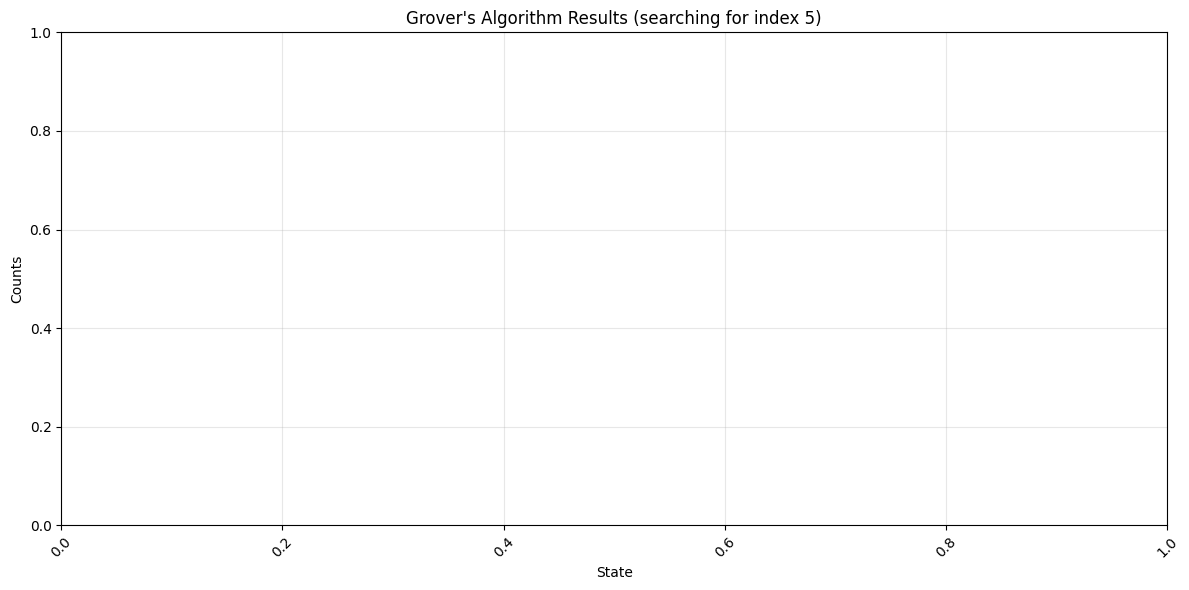

In [26]:
# Create histogram with proper formatting
plt.figure(figsize=(12, 6))
plot_histogram(counts)
plt.title(f"Grover's Algorithm Results (searching for index {secret_index})")
plt.xlabel('State')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()